In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pprint
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")
import arviz as az
import scipy
import matplotlib.patches as patches
import statsmodels.stats.api as sms
from sklearn.metrics import r2_score
import scipy.stats.kde as kde

# Read meta data

In [26]:
df_meta = pd.read_csv('PathTable_meta.tsv', sep='\t', index_col=0)
df_meta = df_meta[['group','subject','day']]
df_meta = df_meta[df_meta.group=='W']
df_meta = df_meta.drop('group', axis=1)
df_meta.columns = ['Subject','Day']
df_meta.head()

,Subject,Day
#SampleID,,
DBH1W00101,1W001,0
DBH1W00102,1W001,28
DBH1W00103,1W001,56
DBH1W00104,1W001,84
DBH1W00201,1W002,0


# Read SCFA

In [15]:
df_scfa = pd.read_csv('PathTable_meta.tsv', sep='\t', index_col=0)
df_scfa = df_scfa[['Acetic acid','Butyric acid','Propionic acid']]
df_scfa.columns = ['Acetate','Butyrate','Propionate']
df_scfa = df_scfa.loc[df_meta.index]
df_scfa.head()

,Acetate,Butyrate,Propionate
#SampleID,,,
DBH1W00101,42.335642,36.576077,31.580772
DBH1W00102,94.225708,59.082440,44.585360
DBH1W00103,70.218036,50.572825,38.977819
DBH1W00104,129.750896,90.187198,65.116987
DBH1W00201,98.949275,60.963995,43.151904


In [16]:
df_scfa.corr()

,Acetate,Butyrate,Propionate
Acetate,1.000000,0.602491,0.596165
Butyrate,0.602491,1.000000,0.499459
Propionate,0.596165,0.499459,1.000000


# Read MGS data (relative abundance)

In [35]:
df_MGS = pd.read_excel('MGS_relative_abundance.xlsx', index_col=0)
df_MGS = df_MGS.loc[df_meta.index]
df_MGS.head()

,Bacteroides uniformis,Bacteroides xylanisolvens,Bacteroides stercoris,Bacteroides ovatus,Bacteroides caccae,Bacteroides thetaiotaomicron,Bacteroides fragilis,Bacteroides intestinalis,Bacteroides eggerthii,Bacteroides fragilis_A,...,Pseudozobellia thermophila,BACL21 sp002694465,Pantoea rodasii,Tachikawaea gelatinosa,AG-426-I14 sp003213175,Convivina intestini,Parageobacillus galactosidasius,AG-409-J16 sp003215655,UBA5194 sp002412935,GCA-2746535 sp002746535
#SampleID,,,,,,,,,,,,,,,,,,,,,
DBH1W00101,0.103458,0.108759,0.062066,0.082845,0.021732,0.020477,0.006537,0.004749,0.002593,0.001340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DBH1W00102,0.067379,0.006621,0.018305,0.049871,0.018404,0.009712,0.001669,0.000106,0.001615,0.000187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DBH1W00103,0.000184,0.000187,0.000215,0.000281,0.000050,0.000147,0.005202,0.000002,0.000031,0.000021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DBH1W00104,0.000215,0.000156,0.000029,0.000292,0.000034,0.000089,0.000054,0.000000,0.000052,0.000004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DBH1W00201,0.009104,0.004670,0.005764,0.004424,0.000113,0.004620,0.001718,0.000019,0.000044,0.000100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Select the 40 most abundant taxa

In [38]:
topX = 40
df_MGS_T = df_MGS.T
df_MGS_T['mean'] = df_MGS_T.mean(axis=1)
df_MGS_T = df_MGS_T.sort_values(by=['mean'],axis=0,ascending=False)
df_MGS_T = df_MGS_T.drop('mean', axis=1)
df_MGS_topX = df_MGS_T.iloc[0:topX].T
df_MGS_topX.head()

,Prevotella copri,Bifidobacterium pseudocatenulatum,Bifidobacterium longum,Bacteroides_B vulgatus,Agathobacter rectale,Bacteroides uniformis,Agathobacter faecis,Fusicatenibacter saccharivorans,Faecalibacterium prausnitzii_C,Parabacteroides distasonis,...,Bifidobacterium breve,Olsenella_B sp000752675,Blautia_A massiliensis,Bacteroides_A coprocola,Klebsiella pneumoniae,Faecalibacterium prausnitzii_E,Ruminococcus_D bicirculans,Lactobacillus_H mucosae,Prevotella buccae,Lachnospira eligens_B
#SampleID,,,,,,,,,,,,,,,,,,,,,
DBH1W00101,0.000387,0.034076,0.021804,0.128373,0.000629,0.103458,0.000386,0.000217,0.001059,0.030177,...,0.000530,0.000002,0.001294,0.000298,0.028550,0.000453,0.000005,0.001578,0.000006,0.000200
DBH1W00102,0.000927,0.081381,0.134484,0.079870,0.000762,0.067379,0.000382,0.000274,0.001126,0.160462,...,0.003141,0.000002,0.001173,0.000250,0.000896,0.000446,0.000009,0.009863,0.001875,0.000146
DBH1W00103,0.156179,0.244621,0.296205,0.000883,0.000185,0.000184,0.000112,0.000152,0.000083,0.000245,...,0.007520,0.000002,0.000059,0.000074,0.000276,0.000010,0.000013,0.089392,0.000003,0.000019
DBH1W00104,0.078140,0.295985,0.319400,0.001793,0.000437,0.000215,0.000083,0.018365,0.000154,0.000351,...,0.008365,0.000002,0.000423,0.000023,0.000274,0.000029,0.000006,0.081844,0.000001,0.000051
DBH1W00201,0.052423,0.000204,0.000922,0.010438,0.023272,0.009104,0.010242,0.003838,0.004366,0.005780,...,0.000011,0.000000,0.000683,0.000334,0.000947,0.000479,0.000069,0.000296,0.000089,0.080676


In [39]:
# sample with minimum absolute abundance coverage
(df_MGS_topX.sum(axis=1)/df_MGS.sum(axis=1)).min()

0.2706005959439309

# Calculate derivative

In [40]:
df_scfa_meta = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_deriv = deepcopy(df_scfa_meta)
for curr_mice in set(df_scfa_deriv.Subject):
    curr_df = df_scfa_meta[df_scfa_meta.Subject==curr_mice]
    for scfa in ['Acetate','Butyrate','Propionate']:
        xdata = np.array(curr_df['Day'])
        ydata = np.array(curr_df[scfa])
        cs = CubicSpline(xdata, ydata)
        csd1 = cs.derivative(nu=1)
        ydata_d1 = csd1(xdata)
        df_scfa_deriv.loc[df_scfa_deriv.Subject==curr_mice, scfa] = ydata_d1
    
df_scfa_deriv = df_scfa_deriv[['Acetate','Butyrate','Propionate']]
df_scfa_deriv.head()

,Acetate,Butyrate,Propionate
#SampleID,,,
DBH1W00101,5.106608,2.299798,1.396319
DBH1W00102,-0.451137,-0.221129,-0.167665
DBH1W00103,-0.314659,0.084371,0.066881
DBH1W00104,5.516043,3.216298,2.099957
DBH1W00201,12.257970,8.138579,5.382485


# Normalize max value of 16S data to 1

In [41]:
# normalize bacteria data using 
bacterial_taxa = list(df_MGS_topX.columns)
df_MGS_topX = df_MGS_topX/df_MGS_topX.max().max()
df_MGS_topX.head()

,Prevotella copri,Bifidobacterium pseudocatenulatum,Bifidobacterium longum,Bacteroides_B vulgatus,Agathobacter rectale,Bacteroides uniformis,Agathobacter faecis,Fusicatenibacter saccharivorans,Faecalibacterium prausnitzii_C,Parabacteroides distasonis,...,Bifidobacterium breve,Olsenella_B sp000752675,Blautia_A massiliensis,Bacteroides_A coprocola,Klebsiella pneumoniae,Faecalibacterium prausnitzii_E,Ruminococcus_D bicirculans,Lactobacillus_H mucosae,Prevotella buccae,Lachnospira eligens_B
#SampleID,,,,,,,,,,,,,,,,,,,,,
DBH1W00101,0.000561,0.049389,0.031602,0.186060,0.000912,0.149948,0.000559,0.000314,0.001534,0.043737,...,0.000768,0.000003,0.001875,0.000433,0.041380,0.000657,0.000008,0.002288,0.000009,0.000290
DBH1W00102,0.001343,0.117951,0.194917,0.115761,0.001105,0.097656,0.000554,0.000397,0.001632,0.232567,...,0.004552,0.000003,0.001699,0.000363,0.001299,0.000646,0.000013,0.014294,0.002717,0.000212
DBH1W00103,0.226360,0.354545,0.429308,0.001280,0.000268,0.000266,0.000163,0.000220,0.000121,0.000355,...,0.010899,0.000003,0.000085,0.000107,0.000400,0.000015,0.000018,0.129561,0.000004,0.000028
DBH1W00104,0.113254,0.428990,0.462926,0.002598,0.000633,0.000312,0.000120,0.026617,0.000223,0.000509,...,0.012124,0.000003,0.000612,0.000033,0.000397,0.000042,0.000009,0.118622,0.000001,0.000074
DBH1W00201,0.075980,0.000296,0.001337,0.015129,0.033730,0.013195,0.014844,0.005563,0.006327,0.008377,...,0.000016,0.000000,0.000991,0.000484,0.001372,0.000695,0.000100,0.000429,0.000129,0.116928


# Simple Correlation

In [45]:
lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    for t in bacterial_taxa:
        lines.append([scfa,
                     t,
                     pearsonr(df_scfa_deriv[scfa],df_MGS_topX[t])[0],
                     spearmanr(df_scfa_deriv[scfa],df_MGS_topX[t])[0]]
                    )
df_corr = pd.DataFrame(lines, columns=['SCFA','Variable','Pearson','Spearman'])
df_corr.head()

,SCFA,Variable,Pearson,Spearman
0,Acetate,Prevotella copri,-0.171565,0.069917
1,Acetate,Bifidobacterium pseudocatenulatum,-0.050848,-0.041985
2,Acetate,Bifidobacterium longum,-0.008860,0.020826
3,Acetate,Bacteroides_B vulgatus,-0.060257,-0.076110
4,Acetate,Agathobacter rectale,-0.110934,0.061410


In [46]:
df_corr.to_excel('correlation_top40.xlsx')

# Elastic net

In [47]:
rows = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_MGS_topX.values)
    l1_ratio = [1e-4, .1, .3, .5, .7, .9, .95, .99, 1]
    reg = ElasticNetCV(
        eps=1e-4,
        n_alphas=10000,
        cv=5,
        random_state=0,
        max_iter=100000,
        tol=1e-6,
        l1_ratio=l1_ratio
    ).fit(X, dydt)
    clf = ElasticNet(l1_ratio=reg.l1_ratio_, 
                     alpha=reg.alpha_, 
                     random_state=0,
                     max_iter=100000,
                     tol=1e-6,
                    ).fit(X,dydt)
    rows.append([scfa, reg.alpha_, reg.l1_ratio_, clf.score(X,dydt)]+ list(clf.coef_))
df_elasticnet = pd.DataFrame(rows, columns=['SCFA','BestAlpha','L1Ratio','R2']+list(df_MGS_topX.columns)).set_index('SCFA')
#df_elasticnet = df_elasticnet.loc[:, (df_elasticnet != 0).any(axis=0)]
df_elasticnet.head()

,BestAlpha,L1Ratio,R2,Prevotella copri,Bifidobacterium pseudocatenulatum,Bifidobacterium longum,Bacteroides_B vulgatus,Agathobacter rectale,Bacteroides uniformis,Agathobacter faecis,...,Bifidobacterium breve,Olsenella_B sp000752675,Blautia_A massiliensis,Bacteroides_A coprocola,Klebsiella pneumoniae,Faecalibacterium prausnitzii_E,Ruminococcus_D bicirculans,Lactobacillus_H mucosae,Prevotella buccae,Lachnospira eligens_B
SCFA,,,,,,,,,,,,,,,,,,,,,
Acetate,0.014000,0.90,0.281192,-30.545299,-13.156439,-7.464459,-28.876474,-36.850798,-15.004735,0.0,...,-14.827852,-0.0,-0.0,-23.435833,128.611332,-6.214323,19.388834,-0.0,-5.551589,0.0
Butyrate,0.092597,0.99,0.119947,0.000000,-0.000000,-11.243899,-0.000000,0.000000,-0.000000,0.0,...,-0.000000,0.0,-0.0,0.000000,38.827203,-0.000000,0.000000,-0.0,0.000000,0.0
Propionate,0.185101,1.00,0.163923,-0.000000,0.000000,0.000000,-11.962874,-0.000000,-0.000000,-0.0,...,-0.000000,0.0,-0.0,-0.000000,65.568781,-0.000000,-0.000000,-0.0,0.000000,0.0


In [48]:
df_elasticnet = df_elasticnet.stack().reset_index()
df_elasticnet = df_elasticnet[~df_elasticnet.level_1.isin(['BestAlpha','L1Ratio','R2'])]
df_elasticnet.columns=['SCFA','Variable','Coefficient']
df_elasticnet = df_elasticnet.reset_index(drop=True)
df_elasticnet.to_excel('elasticnet_summary_top40.xlsx')

# Random forest regression

## parameter optimization

In [49]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_MGS_topX.values)

    # grid search
    rf = RandomForestRegressor()
    rf_random = GridSearchCV(
        estimator = rf, 
        param_grid = random_grid, 
        cv = 5, 
        verbose=2, 
        n_jobs = -1)

    # fit the random search model
    rf_random.fit(X, dydt)
    
    # write to table
    lines.append([scfa,
           rf_random.best_params_['n_estimators'],
           rf_random.best_params_['max_features'],
           rf_random.best_params_['max_depth'],
           rf_random.best_params_['min_samples_split'],
           rf_random.best_params_['min_samples_leaf'],
           rf_random.best_params_['bootstrap']
           ])

df_opt_paras = pd.DataFrame(lines, columns=['SCFA','n_estimators','max_features','max_depth','min_samples_split','min_samples_leaf','bootstrap'])
df_opt_paras.head()

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 45.1min finished


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 35.9min finished


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 32.4min finished


,SCFA,n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap
0,Acetate,200,auto,30,5,4,True
1,Butyrate,200,sqrt,20,2,2,True
2,Propionate,650,sqrt,20,5,4,True


In [53]:
df_opt_paras.to_excel('optimal_rf_hyperparameters_top40.xlsx')

## run RF using best parameters

In [54]:
rows = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_MGS_topX.values)
    regr = RandomForestRegressor(
        random_state=0,
        bootstrap=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'bootstrap'])[0],
        max_depth=None if str(list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0])=='nan' else list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0],
        max_features=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_features'])[0],
        min_samples_leaf=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_leaf'])[0],
        min_samples_split=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_split'])[0],
        n_estimators=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'n_estimators'])[0],
        n_jobs=-1
    )
    clf = regr.fit(X, dydt)
    rows.append([scfa, clf.score(X, dydt)]+ list(clf.feature_importances_))
df_rf = pd.DataFrame(rows, columns=['SCFA','R2']+list(df_MGS_topX.columns))
df_rf.head()

,SCFA,R2,Prevotella copri,Bifidobacterium pseudocatenulatum,Bifidobacterium longum,Bacteroides_B vulgatus,Agathobacter rectale,Bacteroides uniformis,Agathobacter faecis,Fusicatenibacter saccharivorans,...,Bifidobacterium breve,Olsenella_B sp000752675,Blautia_A massiliensis,Bacteroides_A coprocola,Klebsiella pneumoniae,Faecalibacterium prausnitzii_E,Ruminococcus_D bicirculans,Lactobacillus_H mucosae,Prevotella buccae,Lachnospira eligens_B
0,Acetate,0.570542,0.076233,0.018970,0.070900,0.016966,0.011992,0.018460,0.018697,0.019906,...,0.025984,0.018665,0.011085,0.030962,0.052630,0.020403,0.046314,0.018860,0.023092,0.017125
1,Butyrate,0.724989,0.022210,0.024752,0.036267,0.020107,0.016813,0.014559,0.019910,0.031490,...,0.031822,0.033893,0.020968,0.039379,0.040324,0.027941,0.022573,0.034541,0.019263,0.020570
2,Propionate,0.473780,0.048550,0.025890,0.058566,0.028689,0.017491,0.011245,0.015046,0.022406,...,0.030351,0.031273,0.018003,0.040753,0.039332,0.018255,0.017579,0.011036,0.011040,0.022500


In [55]:
df_rf = df_rf.set_index('SCFA').stack().reset_index()
df_rf = df_rf[~df_rf.level_1.isin(['R2'])]
df_rf.columns=['SCFA','Variable','Gini']
df_rf = df_rf.reset_index(drop=True)
df_rf.to_excel('rf_importance_top40.xlsx')

# Combine results

In [2]:
df_corr = pd.read_excel('correlation_top40.xlsx', index_col=0)
df_corr = df_corr.drop('Spearman', axis=1)
df_corr.head()

,SCFA,Variable,Pearson
0,Acetate,Prevotella copri,-0.171565
1,Acetate,Bifidobacterium pseudocatenulatum,-0.050848
2,Acetate,Bifidobacterium longum,-0.008860
3,Acetate,Bacteroides_B vulgatus,-0.060257
4,Acetate,Agathobacter rectale,-0.110934


In [3]:
df_elasnet = pd.read_excel('elasticnet_summary_top40.xlsx', index_col=0)
df_elasnet.head()

,SCFA,Variable,Coefficient
0,Acetate,Prevotella copri,-30.545299
1,Acetate,Bifidobacterium pseudocatenulatum,-13.156439
2,Acetate,Bifidobacterium longum,-7.464459
3,Acetate,Bacteroides_B vulgatus,-28.876474
4,Acetate,Agathobacter rectale,-36.850798


In [4]:
df_rf = pd.read_excel('rf_importance_top40.xlsx', index_col=0)
df_rf.head()

,SCFA,Variable,Gini
0,Acetate,Prevotella copri,0.076233
1,Acetate,Bifidobacterium pseudocatenulatum,0.018970
2,Acetate,Bifidobacterium longum,0.070900
3,Acetate,Bacteroides_B vulgatus,0.016966
4,Acetate,Agathobacter rectale,0.011992


In [5]:
df_joined = pd.merge(df_rf, df_corr, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined = pd.merge(df_joined, df_elasnet, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined.columns = ['SCFA','Taxon','RandomForest','Pearson','ElasticNet']
df_joined['Taxon'] = [t.replace('_dash_','-').replace('_dot_','.') for t in df_joined['Taxon']]
df_joined.head()

,SCFA,Taxon,RandomForest,Pearson,ElasticNet
0,Acetate,Prevotella copri,0.076233,-0.171565,-30.545299
1,Acetate,Bifidobacterium pseudocatenulatum,0.018970,-0.050848,-13.156439
2,Acetate,Bifidobacterium longum,0.070900,-0.008860,-7.464459
3,Acetate,Bacteroides_B vulgatus,0.016966,-0.060257,-28.876474
4,Acetate,Agathobacter rectale,0.011992,-0.110934,-36.850798


In [9]:
df_joined[(df_joined.SCFA=='Acetate') & (df_joined.ElasticNet>0)].sort_values(by='RandomForest', ascending=False)

,SCFA,Taxon,RandomForest,Pearson,ElasticNet
34,Acetate,Klebsiella pneumoniae,0.052630,0.443030,128.611332
36,Acetate,Ruminococcus_D bicirculans,0.046314,0.121680,19.388834
20,Acetate,Escherichia flexneri,0.040870,0.171698,31.086407
26,Acetate,Bifidobacterium adolescentis,0.030863,0.086571,11.511106
10,Acetate,Prevotella copri_A,0.025689,0.143894,44.351151


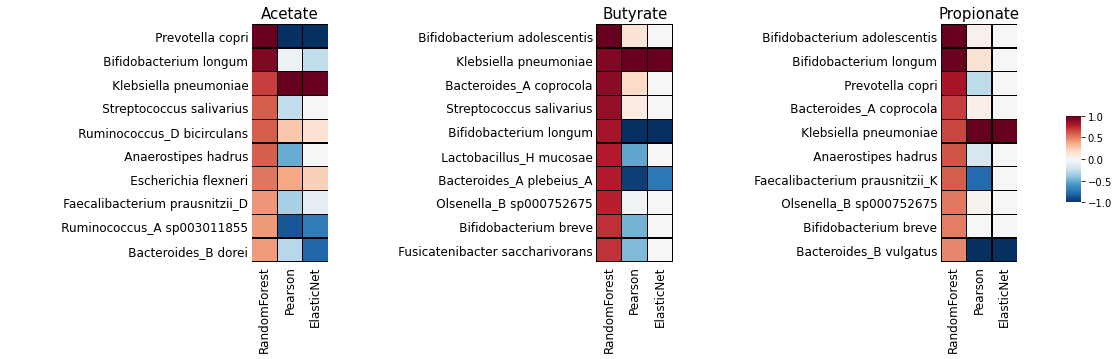

In [7]:
fig, ax = plt.subplots(figsize=(14, 6), nrows=1, ncols=3, constrained_layout=True, sharex=True)
cbar_ax = fig.add_axes([0.94, .45, .015, .2])
for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    curr_df = df_joined[df_joined.SCFA==scfa].set_index('Taxon')
    curr_df = curr_df.drop('SCFA', axis=1)
    curr_df = curr_df.sort_values(by='RandomForest', ascending=False)
    curr_df = curr_df.iloc[0:10, :]
     
    # normalize to -1 and 1
    for c in ['ElasticNet','Pearson','RandomForest']:
        if c!='RandomForest':
            curr_df.loc[curr_df[c]<0,c] = curr_df.loc[curr_df[c]<0,c]/np.abs(curr_df.loc[curr_df[c]<0,c].min())
        curr_df.loc[curr_df[c]>=0,c] = curr_df.loc[curr_df[c]>=0,c]/curr_df.loc[curr_df[c]>=0,c].max()

    # plot    
    _ = sns.heatmap(curr_df.values, ax=ax[k], cmap='RdBu_r', vmin=-1, vmax=1, cbar = False if k!=2 else True, cbar_ax = None if k!=2 else cbar_ax, linewidths=0.25, linecolor='black')
    ax[k].set_xticklabels(['RandomForest','Pearson','ElasticNet'], rotation=90, fontsize=12)
    ax[k].set_title(scfa, fontsize=15)
    ax[k].set_yticklabels(curr_df.index, rotation=0, fontsize=12)
    ax[k].tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()

In [33]:
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scfa_producer_top10.pdf", format="pdf")